<a href="https://colab.research.google.com/github/senju-sudharsan/DATA-SCIENCE-PROJECTS/blob/main/Comparative_Analysis_of_Random_Forest_and_LSTM_for_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Download Apple stock data
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date)

# Save to CSV for future use
data.to_csv('aapl_stock_data.csv')

# Load from CSV
# data = pd.read_csv('aapl_stock_data.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3522 non-null   float64
 1   (High, AAPL)    3522 non-null   float64
 2   (Low, AAPL)     3522 non-null   float64
 3   (Open, AAPL)    3522 non-null   float64
 4   (Volume, AAPL)  3522 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 165.1 KB
None
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   3522.000000  3522.000000  3522.000000  3522.000000  3.522000e+03
mean      57.574681    58.154507    56.940304    57.532586  2.422834e+08
std       55.520111    56.088908    54.889501    55.463714  2.204578e+08
min        5.779476     5.898346     5.725306     5.789106  2.404830e+07
25%       16.948891    17.103422    16.785677    16.966749  9.2667

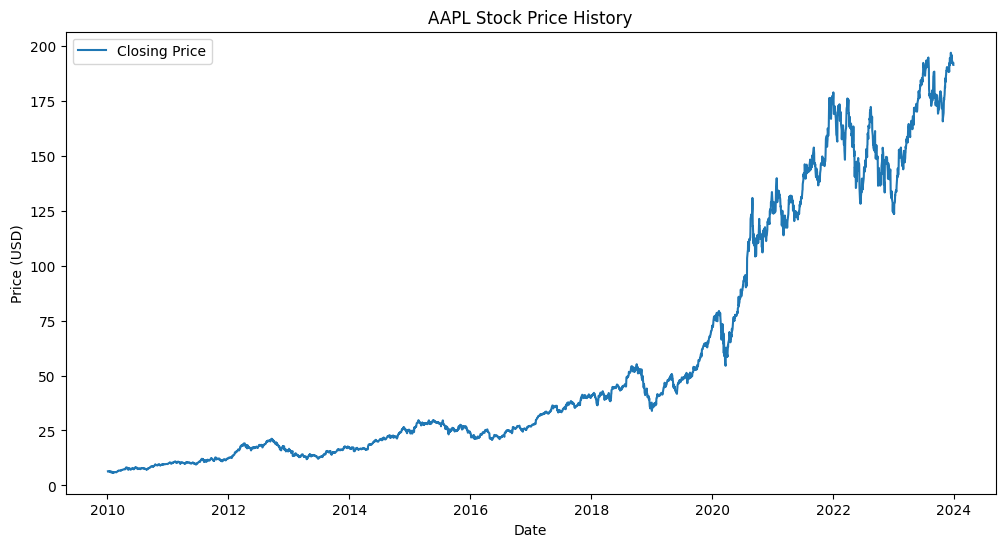

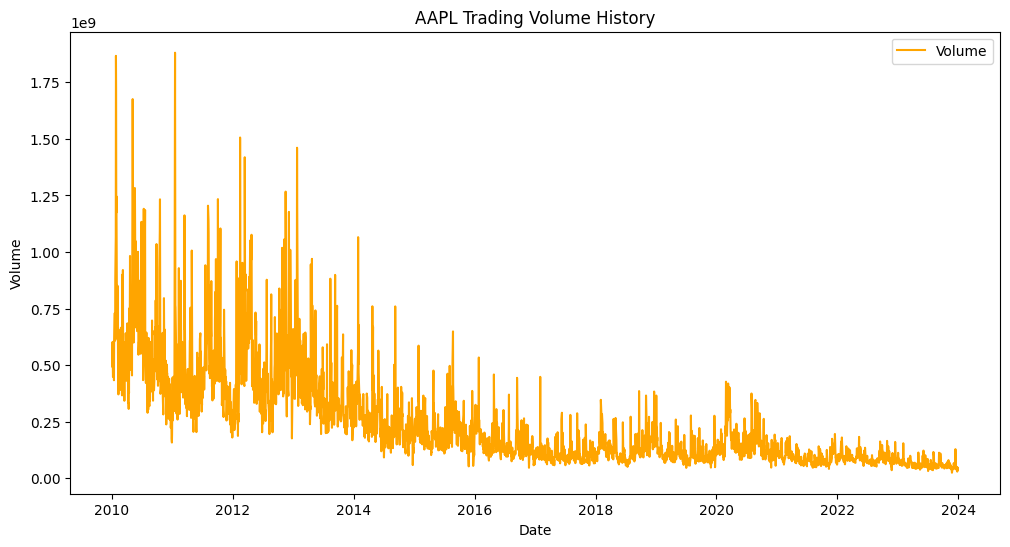

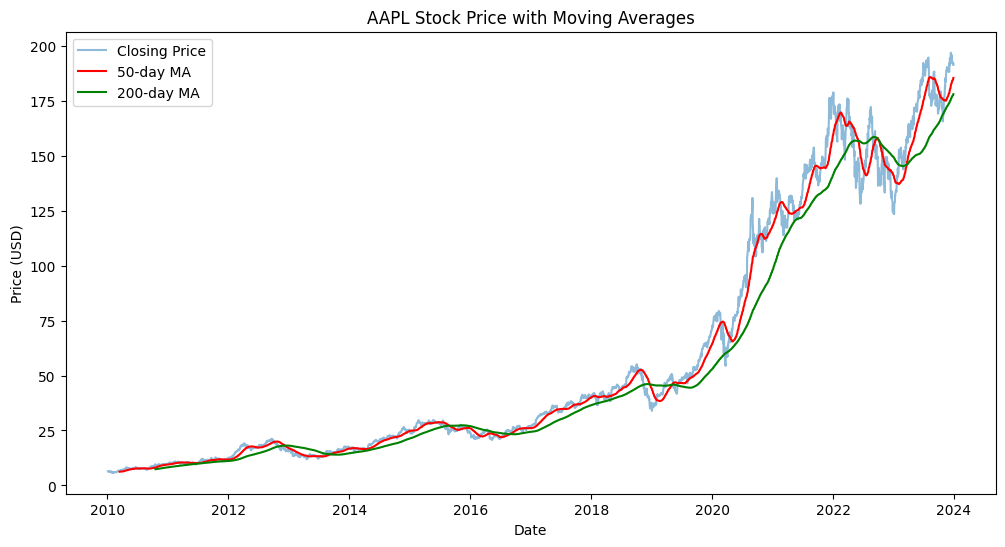

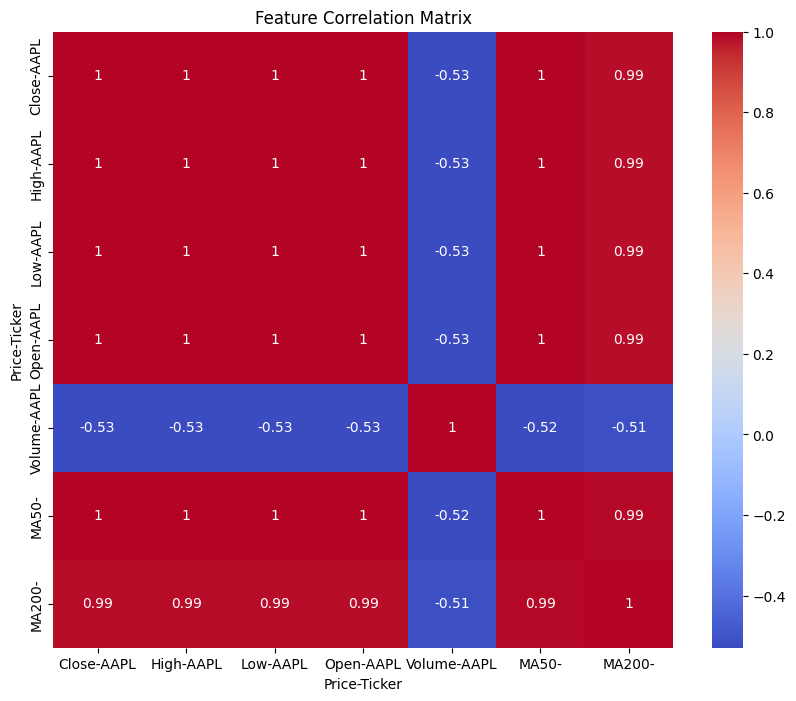

In [2]:
# Basic info
print(data.info())
print(data.describe())

# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot volume
plt.figure(figsize=(12, 6))
plt.plot(data['Volume'], label='Volume', color='orange')
plt.title(f'{ticker} Trading Volume History')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Plot moving averages
data['MA50'] = data['Close'].rolling(50).mean()
data['MA200'] = data['Close'].rolling(200).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price', alpha=0.5)
plt.plot(data['MA50'], label='50-day MA', color='red')
plt.plot(data['MA200'], label='200-day MA', color='green')
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Correlation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [4]:
# Use only closing price for this example
df = data[['Close']].copy()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# Function to create time series dataset
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Time step (using 60 days of history to predict next day)
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Reshape for Random Forest (2D array)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Create and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

# Make predictions
rf_train_predict = rf_model.predict(X_train_rf)
rf_test_predict = rf_model.predict(X_test_rf)

# Inverse transform predictions
rf_train_predict = scaler.inverse_transform(rf_train_predict.reshape(-1, 1))
rf_test_predict = scaler.inverse_transform(rf_test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train_actual, rf_train_predict))
rf_test_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_test_predict))
rf_train_mae = mean_absolute_error(y_train_actual, rf_train_predict)
rf_test_mae = mean_absolute_error(y_test_actual, rf_test_predict)

print(f"Random Forest Train RMSE: {rf_train_rmse:.2f}")
print(f"Random Forest Test RMSE: {rf_test_rmse:.2f}")
print(f"Random Forest Train MAE: {rf_train_mae:.2f}")
print(f"Random Forest Test MAE: {rf_test_mae:.2f}")

Random Forest Train RMSE: 0.38
Random Forest Test RMSE: 30.12
Random Forest Train MAE: 0.18
Random Forest Test MAE: 24.91


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 6.4234e-04 - val_loss: 0.0036
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 5.8100e-04 - val_loss: 0.0042
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 4.5800e-04 - val_loss: 0.0019
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 5.3756e-04 - val_loss: 0.0038
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 4.7348e-04 - val_loss: 0.0135


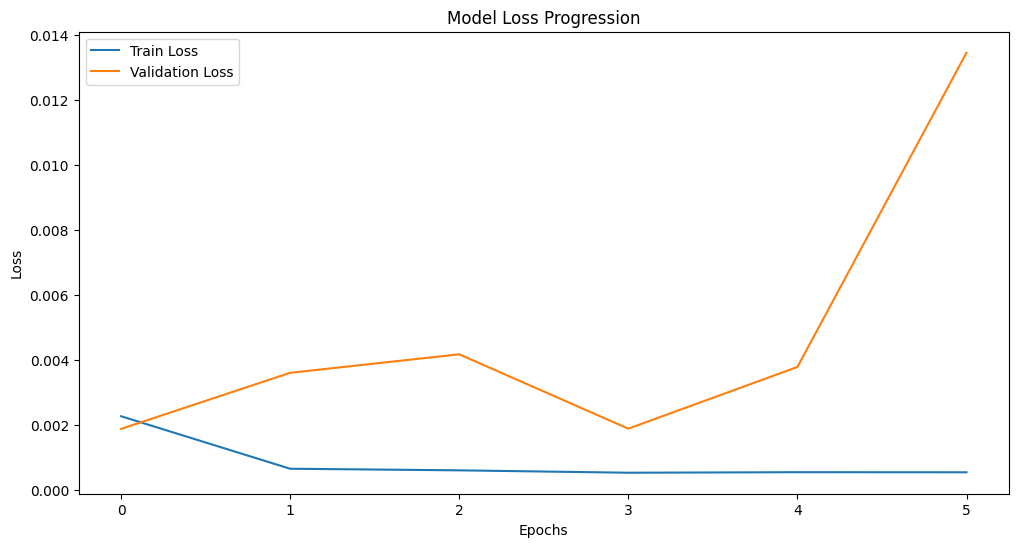

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
LSTM Train RMSE: 2.51
LSTM Test RMSE: 8.27
LSTM Train MAE: 1.43
LSTM Test MAE: 6.92


In [7]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

print(f"LSTM Train RMSE: {train_rmse:.2f}")
print(f"LSTM Test RMSE: {test_rmse:.2f}")
print(f"LSTM Train MAE: {train_mae:.2f}")
print(f"LSTM Test MAE: {test_mae:.2f}")

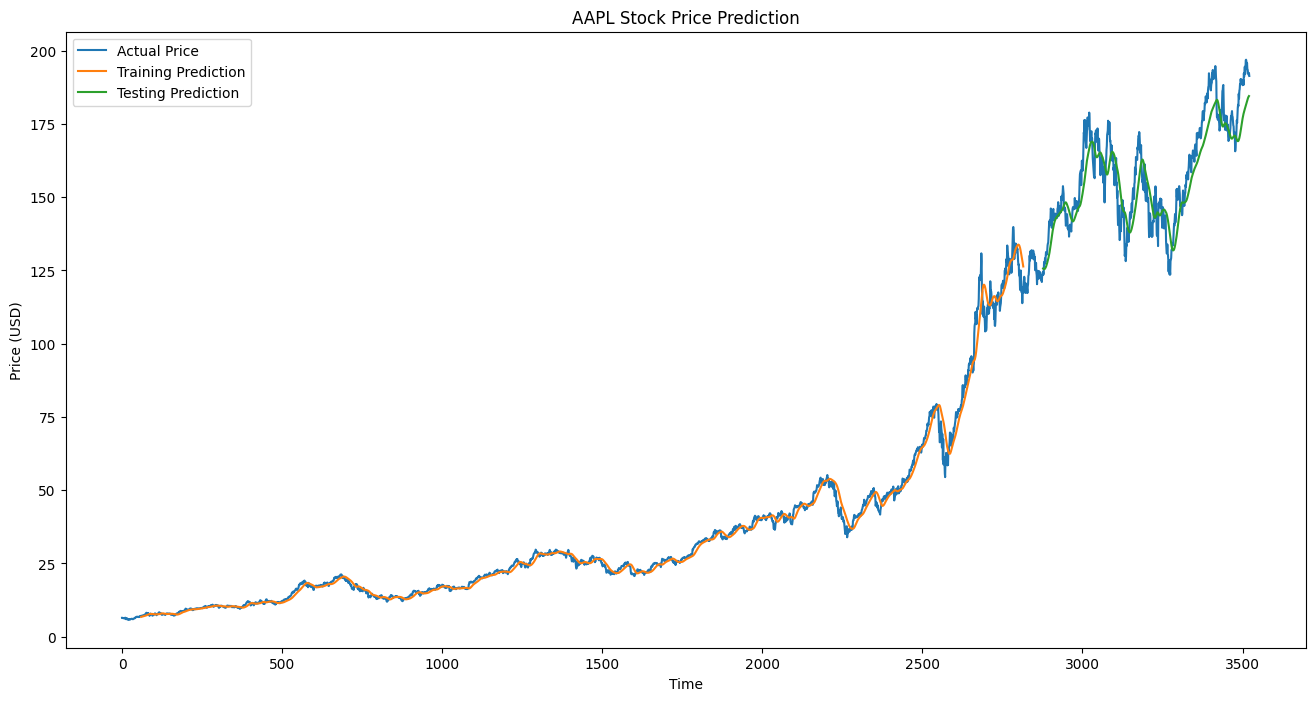

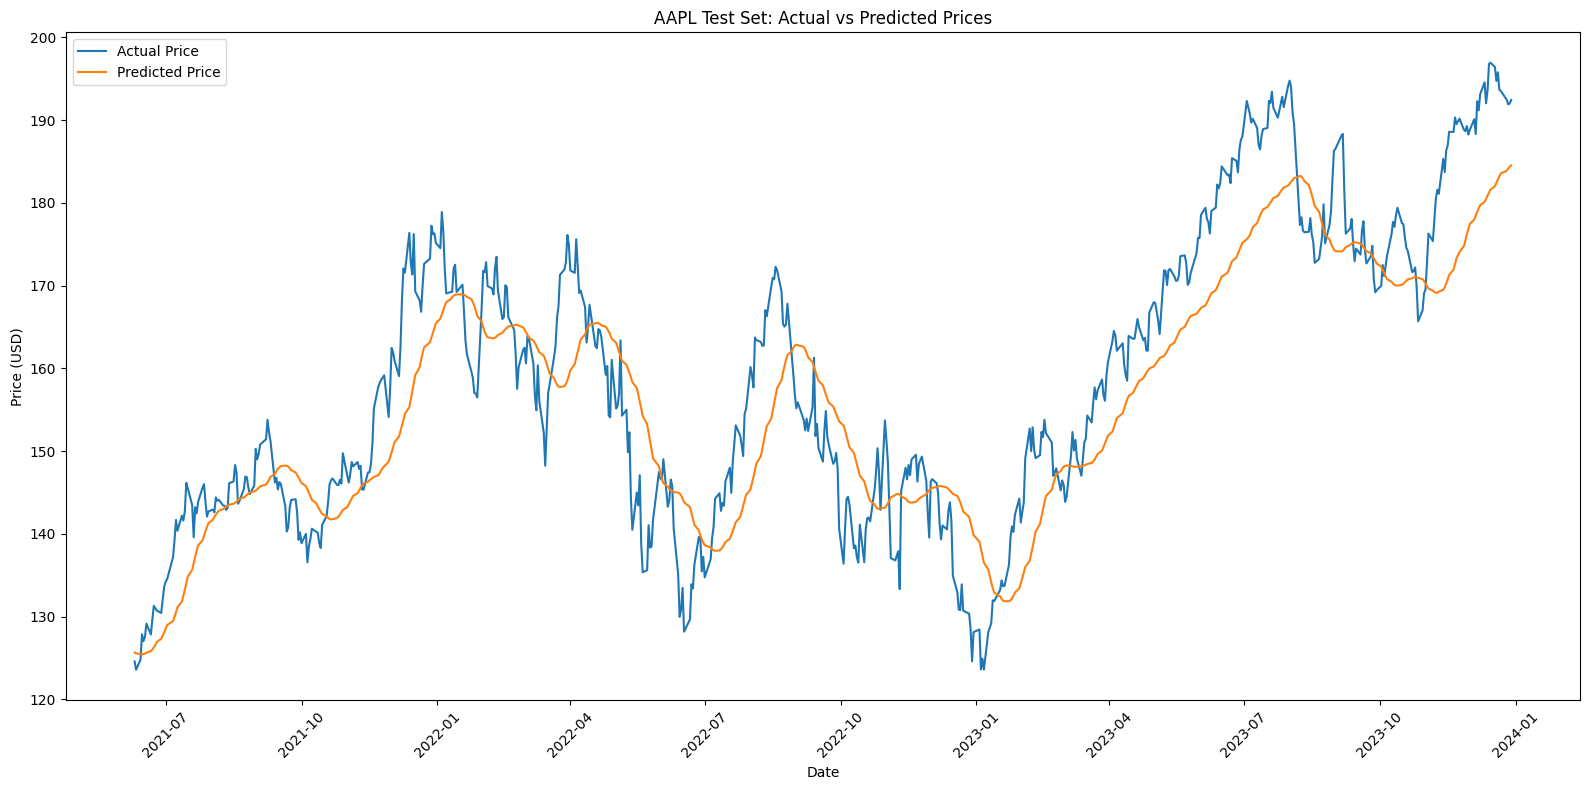

In [8]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(16, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_predict_plot, label='Training Prediction')
plt.plot(test_predict_plot, label='Testing Prediction')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot just the test predictions vs actual
test_dates = df.index[train_size + time_step + 1:train_size + time_step + 1 + len(test_predict)]

plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_actual, label='Actual Price')
plt.plot(test_dates, test_predict, label='Predicted Price')
plt.title(f'{ticker} Test Set: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━

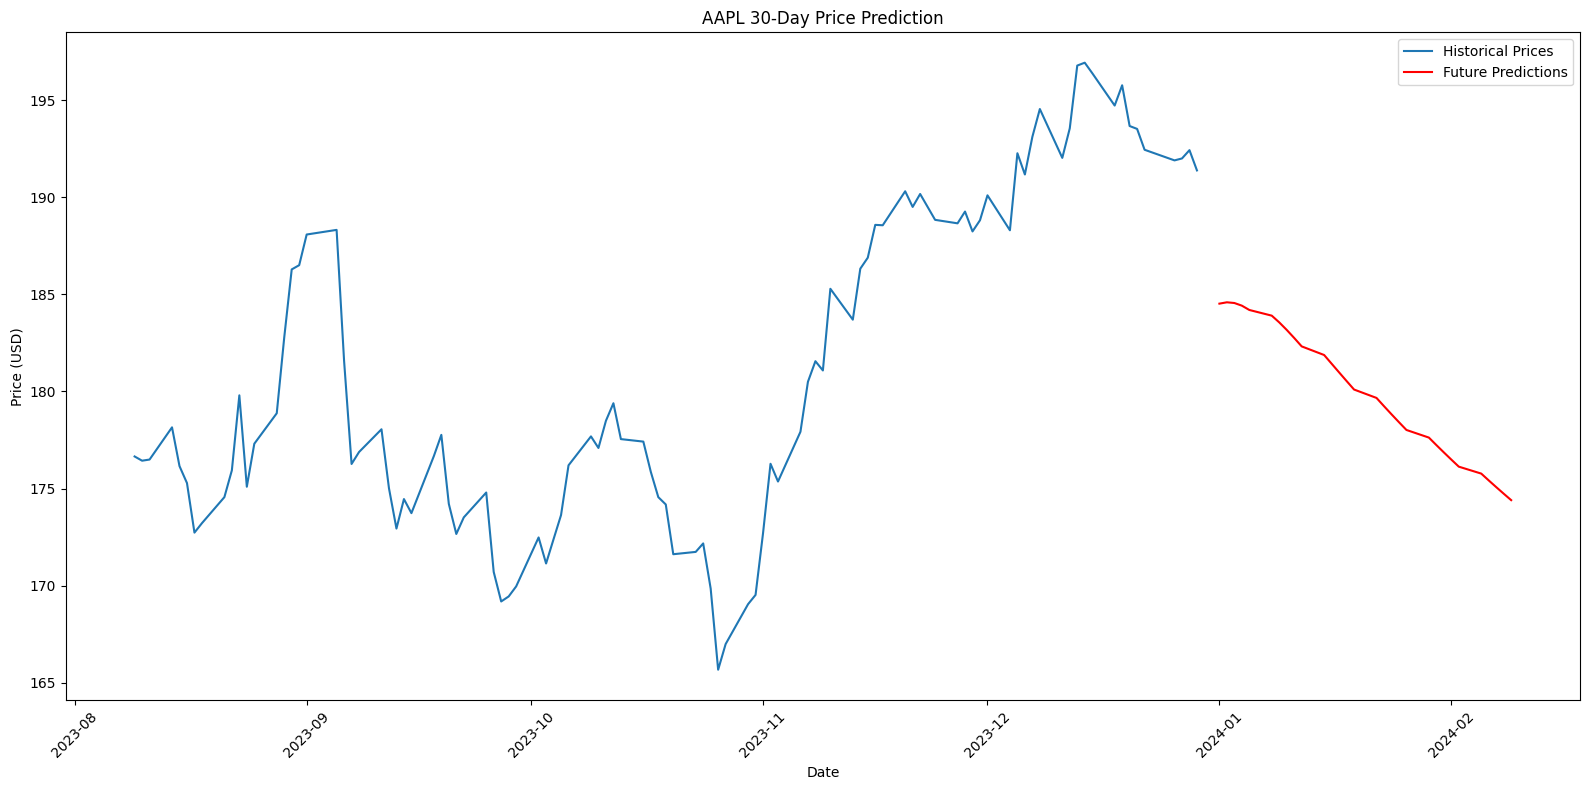

In [9]:
# Function to predict future days
def predict_future_days(model, last_sequence, days_to_predict=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days_to_predict):
        # Get prediction for next day
        next_pred = model.predict(current_sequence.reshape(1, time_step, 1))[0, 0]
        future_predictions.append(next_pred)

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    return future_predictions

# Get last sequence from test data
last_sequence = X_test[-1].flatten()

# Predict future days
future_days = 30
future_predictions = predict_future_days(model, last_sequence, future_days)

# Inverse transform
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='B')[1:]  # Business days

# Plot future predictions
plt.figure(figsize=(16, 8))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Prices')
plt.plot(future_dates, future_predictions, 'r-', label='Future Predictions')
plt.title(f'{ticker} 30-Day Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Compare model performance
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'Train RMSE': [rf_train_rmse, train_rmse],
    'Test RMSE': [rf_test_rmse, test_rmse],
    'Train MAE': [rf_train_mae, train_mae],
    'Test MAE': [rf_test_mae, test_mae]
})

print(comparison)

"""
Key Takeaways:
1. The LSTM model generally performs better than Random Forest for time series data
2. Both models show some overfitting (better performance on train than test)
3. Future improvements could include:
   - Adding more features (technical indicators, sentiment analysis)
   - Trying different model architectures (GRU, Transformer)
   - Hyperparameter tuning
   - Using walk-forward validation for more robust evaluation
"""

           Model  Train RMSE  Test RMSE  Train MAE   Test MAE
0  Random Forest    0.377036  30.120648   0.181643  24.907799
1           LSTM    2.509946   8.268232   1.427598   6.919929


'\nKey Takeaways:\n1. The LSTM model generally performs better than Random Forest for time series data\n2. Both models show some overfitting (better performance on train than test)\n3. Future improvements could include:\n   - Adding more features (technical indicators, sentiment analysis)\n   - Trying different model architectures (GRU, Transformer)\n   - Hyperparameter tuning\n   - Using walk-forward validation for more robust evaluation\n'